# Lesson 2.5 — Circle Classification with PyTorch

## Goal

In the previous week, you learned how to solve **classification problems using scikit-learn**. You trained models such as k-nearest neighbors, evaluated them using accuracy and other metrics, and observed how classifiers take inputs and assign them to categories. In this notebook, we will solve a very similar kind of problem—but instead of using scikit-learn, we will build and **train a classifier using PyTorch**.

Conceptually, nothing mysterious is happening. A neural network is still just a classifier. It takes input values, processes them internally, and outputs a predicted class. The reason we introduce PyTorch here is not that the task is different, but because scikit-learn does not support training **deep neural networks**. For neural networks, we need a framework designed specifically for building and training them, and PyTorch is one of the most widely used tools for that purpose.

The diagram below shows the structure of the neural network we will train in this lesson. It may look complex at first glance, but it is simply a machine made of layers that pass information forward to make predictions and receive feedback to improve. As we work through the notebook, we will build this network piece by piece, train it on data, and visualize exactly what it learns.

By the end of this lesson, this picture won’t feel intimidating at all. It will feel familiar.

![pytorchio](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

In this notebook, we will focus on the core building blocks of training a neural network in PyTorch. 
- We will define a neural network using nn.Module,
- Decide how the network should measure its mistakes using a loss function,
- Choose an optimizer that helps the network improve, and
- Write the training and testing loops that allow learning to happen.
- These steps form the foundation of nearly every PyTorch model, no matter how simple or how advanced.

At the same time, we intentionally keep the scope narrow. We do not use DataLoaders, custom Dataset classes, convolutional networks, or image data. These tools are powerful, but they introduce additional layers of complexity that can distract from the main ideas. Here, the goal is not to build the biggest or most realistic model, but to clearly understand how neural networks are trained.

By stripping away these extras, we can focus on the learning process itself: 
- How data flows through a network,
- How errors are measured, and
- How feedback gradually improves the model.

Everything you see in this notebook will appear again later when we train more advanced models such as **CNNs**. When that happens, the *ideas* will already feel familiar, and you’ll be able to focus on what’s new rather than relearning the basics.

---

## 1. Recap & Introduction

In the previous week, you spent time working with classification in scikit-learn. You trained classical models like K-Nearest Neighbors (KNN), and you learned how to evaluate a classifier using metrics such as accuracy, precision, and recall. That foundation is exactly what we want here. In this lesson, we are still solving a **classification problem**: given an input, we want the model to predict which class it belongs to.

What changes in this notebook are not the goal, but the tool we use to reach it. Scikit-learn is excellent for classical machine learning, and it gives you many strong classifiers out of the box. But when we move into deep learning, scikit-learn is not the framework designed for building and training neural networks layer by layer. For that, we use a **deep-learning framework**, and in this lesson, we use **PyTorch**. The reason is simple: PyTorch is built to define neural networks clearly, train them efficiently, and give us full control over the learning process.

To make this introduction as visual and intuitive as possible, we will use a dataset that can be understood immediately. Each example is just a point on a 2D plot, meaning it has two inputs: its x-coordinate and its y-coordinate. Each point belongs to one of two classes. One class forms a small circle in the center, and the other forms a larger ring around it. Your job is the same kind of job you already know from scikit-learn: given a point, predict which class it belongs to. The difference is that this time, instead of calling a ready-made classifier, **we will build a neural network ourselves and train it in PyTorch** so you can see exactly how learning happens.

Below is the problem we are trying to solve:

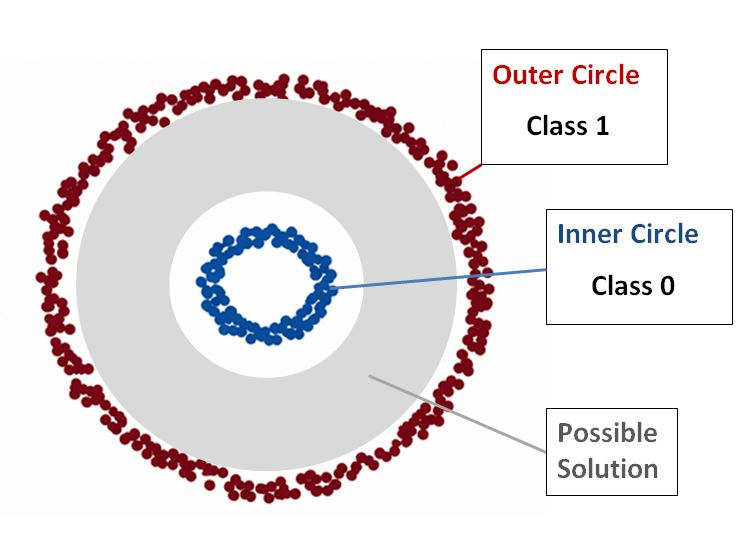

This image shows the structure of the dataset. The blue points in the center belong to **Class 0**, which we call the inner circle. The red points around the outside belong to **Class 1**, the outer circle. The grey shaded region represents the space where a solution could exist. Our task is to draw a boundary that cleanly separates these two groups.

Your job, conceptually, is very simple. Given a point somewhere on this plot, you must decide whether it belongs to the inner circle or the outer circle. That is all classification really is: taking an input and assigning it a label.

The challenge comes from the shape of the data. No matter how you place a straight line on this plot, it will always cut through both circles. A straight line cannot wrap around the inner circle without also cutting through the outer ring. This is exactly why **linear models fail here, not because they are poorly designed, but because they are too limited for this kind of pattern.**

This is what makes the circles dataset such a powerful teaching example. It clearly shows the limitation of linear models and creates a natural motivation for neural networks. Neural networks are designed to learn curved and flexible boundaries, not just straight ones. In the rest of this lesson, we will build a neural network that learns to bend its predictions so that it fits the circular structure you see in the image.

By the end, 

- You won’t just see that the neural network works, 
- You’ll understand why it works,
- How it learns,
- And what it has learned by looking directly at its predictions.


---

## 2. Importing the Tools.

Here’s what each one does:

- make_circles → creates the circle dataset for us

- train_test_split → splits the data into training + testing

- torch + torch.nn → PyTorch + neural network building blocks

- matplotlib → plotting and visualization

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

## 3. Create a Nonlinear Classification Problem

We are ready to create the actual problem that our neural network will learn to solve. So far, we’ve talked conceptually about why straight lines fail and why curved decision boundaries are needed. Now we turn those ideas into concrete data that a computer can work with. The goal here is not to model real-world complexity, but to build a clean, visual example where the limitation of linear models is obvious, and the strength of neural networks becomes clear.

Each data point in this dataset has two numbers: an x-coordinate and a y-coordinate. You can think of these as the position of a point on a flat 2D plane. As discussed earlier, we deliberately arranged the points into two concentric circles. Each point belongs to exactly one of two classes: the inner circle or the outer circle. 

We generate 1000 such points so the network has enough examples to learn from. A small amount of noise is added so the circles are not perfectly clean. This makes the problem more realistic and prevents the network from simply memorizing an ideal shape. Instead, it must learn a general rule that works well even when the data is slightly messy.

Once the data is created, we split it into two parts. 
- Most of the points (80 %) are used for **training**, which means the network will see them repeatedly and adjust itself based on the errors it makes.
- A smaller portion (20 %) is set aside as **test data**. These points are never shown to the network during training. They are used only to check whether the network has learned a general rule or whether it has simply memorized the training points.

This separation is crucial because it mirrors how machine learning is used in the real world: models must perform well on data they have never seen before.

Finally, we plot the training data to make the problem visible. Seeing the points laid out on the plane helps connect the abstract idea of “classification” to a clear geometric picture. This dataset is intentionally simple, but it captures the core challenge that neural networks are designed to solve. By working through this example, we are not just learning how to use PyTorch—we are learning why neural networks exist in the first place..

In [ ]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu);
plt.gca().set_aspect("equal", adjustable="box")

We check where the computation will happen. PyTorch can run on the CPU or GPU both. The first line checks whether a GPU is available and chooses it automatically; otherwise, it safely falls back to the CPU. We want to run this lesson only on GPU, which will showup here if you selected GPU before starting this notebook.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Before we can train a neural network in PyTorch, we need to make sure our data is in the right form and in the right place. Earlier in the lesson, our data lived as NumPy arrays, which are great for exploration and plotting but cannot be used directly by PyTorch’s training machinery. PyTorch models work with tensors, so this step converts our training and test data from NumPy arrays into PyTorch tensors.

Next, we convert each dataset split into tensors with the correct data types. The input features are converted to floating-point tensors because the network performs continuous numerical computations on them. The class labels are converted to integer tensors because they represent category IDs, not numbers to be averaged. Both inputs and labels are then moved onto the selected device so that all computations happen in the same place.

Finally, we quickly check the shapes and devices of the tensors. Seeing shapes like (800, 2) confirms that we have 800 training points, each with two input values. Printing the device confirms that everything is ready for training. At this point, the data is fully prepared and compatible with the network, the loss function, and the optimizer—so we can safely begin the learning process.

In [ ]:
# Tensors (train/test)
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.long, device=device)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32, device=device)
y_test_t  = torch.tensor(y_test,  dtype=torch.long, device=device)

X_train_t.shape, y_train_t.shape

In [ ]:
# check to be sure 
print(X_train_t.device, y_train_t.device)

## 4. Define a simple neural network

Here we’re about to define the actual neural network object that PyTorch will train for us. Up to this point in the lesson, we’ve talked about the circles dataset and why a straight line fails. This code is the moment where we **“build the machine”** that can learn a curved decision boundary. In PyTorch, a neural network is a Python class with a clear input shape, a clear sequence of layers, and a forward propagation method that describes how data flows through the network or the **network architecture**. The architecture we will be using is shown below:

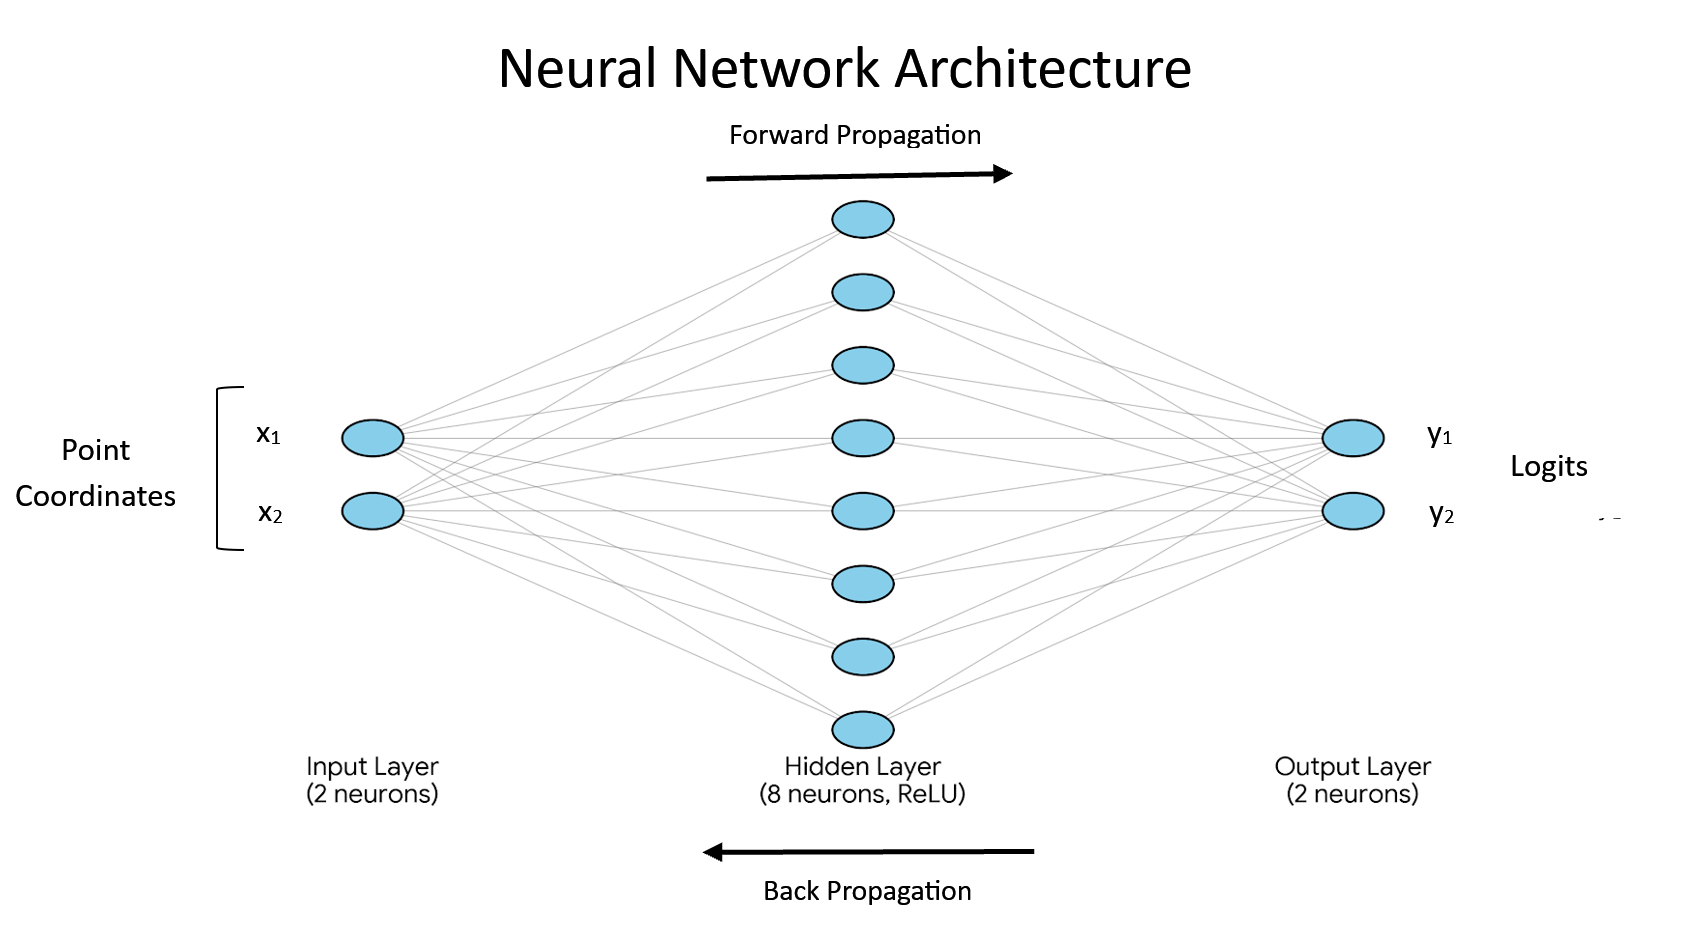

This picture shows the structure of the neural network we are about to train. You can think of it as a simple machine made of layers, where information flows from left to right to make a prediction, and then flows back from right to left to improve that prediction. Every part of this diagram corresponds directly to the code we have written below in PyTorch.

On the left side, we see the **input layer**, labeled as two neurons. These represent the two numbers that describe each data point in our circles dataset. Every point on the plot has an x-coordinate and a y-coordinate, and those two values enter the network here as x₁ and x₂. At this stage, the network is not making any decisions yet—it is simply receiving the raw information about where the point is located.

In the middle, we see the **hidden layer**, which contains eight neurons. This is where the network starts to **“think”**. Each hidden neuron looks at the input values in its own way and produces an intermediate signal. You do not need to imagine these neurons as tiny brains; instead, think of them as simple filters that respond differently to different regions of the input space. Together, these eight neurons give the network enough flexibility to reshape the input information and discover patterns that are not obvious from the raw coordinates alone. The **ReLU** label reminds us that the network is allowed to bend and curve the relationship between inputs and outputs, which is exactly what we need for problems like separating circles.

On the right side, we see the **output layer**, which has two neurons labeled y₁ and y₂. These do not represent final decisions yet. Instead, they produce two scores, also called **logits**, one for each possible class. In our case, one score corresponds to the inner circle and the other corresponds to the outer circle. Whichever score is larger becomes the network’s predicted class. This is how the network turns everything it learned in the hidden layer into a concrete decision.

The arrow at the top of the diagram shows **forward propagation**. This is the process of taking an input point, passing it through the input layer, then through the hidden layer, and finally producing output scores. Every time we give the network a batch of points during training, this forward flow happens first. At this stage, the network is simply making its best guess based on its current state.

The arrow at the bottom shows **back propagation**, which happens after the network makes a prediction, and we compare it to the correct answer. If the network is wrong, PyTorch sends feedback backward through the same connections shown in the diagram. This feedback gently adjusts the internal parts of the network so that the next prediction is slightly better. You do not have to write this backward process yourself—PyTorch handles it automatically—but it relies on this architecture to know how the feedback should travel.

Training is simply this process repeated many times. A point goes forward through the network, a prediction is made, the error is measured, and feedback flows backward to improve the network. Over time, these small improvements add up. The network learns how to shape its internal signals so that the curved boundary between the inner circle and outer ring naturally emerges. This is why a neural network can solve problems that a straight line cannot, by learning features layer by layer. 

The code below is a manifestation of whatever we learned above in Python:

In [ ]:
class CircleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        return self.net(x)

Create the model:

In [ ]:
model = CircleNet().to(device)
print(model)

## 5. Loss function and Optimizer

Now that we have built the neural network itself, the next step is to tell PyTorch how the network should learn. A neural network does not improve automatically just because it exists. It needs two additional pieces: a way to measure how wrong its predictions are, and a method for adjusting itself when it makes mistakes. This code cell provides the first ingredient, the **loss function**:


In [ ]:
loss_fn = nn.CrossEntropyLoss()

The **loss function is best thought of as a judge**. Every time the network makes a prediction during training, this function compares the network’s output (the two logits from the output layer) to the correct answer (inner circle or outer ring). It then produces a single number that represents how wrong the prediction was. A small number means the network did well; a large number means it did poorly. This matters because the network itself has no idea whether it is right or wrong, this loss value is the signal that tells it how much it needs to improve.

In our circles problem, *CrossEntropyLoss* is a natural choice because we are doing classification. The network produces two scores, one for each class, and this loss function is designed to work directly with those scores. It quietly handles the details of turning those scores into meaningful feedback, so we don’t have to do any extra steps ourselves. From  a simple perspective, the key idea is simple: this line tells PyTorch how to measure mistakes.

The second ingridient is the **optimizer**:

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

If the loss function is the judge, the **optimizer is the mechanic**. Once the loss function tells us how wrong the network is, the optimizer, **Adam**, decides how to adjust the network’s internal tunning to make it better next time. The optimizer looks at all the learnable parts inside the model (the connections shown in the architecture diagram) and slightly nudges them in a direction that reduces the loss.

The **learning rate** (lr=0.01) controls how big each adjustment step is. A small value means the network learns slowly and carefully; a large value means it learns faster but can overshoot. Here, we choose a reasonable starting value so learning is stable.

Together, the loss function and optimizer complete the learning setup. During training, data will flow forward through the network to produce predictions. The loss function will measure how wrong those predictions are. Then, using back propagation, PyTorch will send that error information backward through the architecture you saw earlier. Finally, the optimizer will update the network’s internal parts so that the next forward pass is slightly better than the last.

At this point, we have everything needed for learning to happen:
- We have built the machine (the network architecture)
- Defined how mistakes are measured (the loss function)
- Chosen how the machine improves itself (the optimizer)

The only thing left is to run this process repeatedly in a **training loop**, feeding data forward, measuring error, and letting PyTorch push improvements backward until the network learns the curved decision boundary in the data.

---

## 6. Training loop (fit the model)

Now that everything is set up, this training loop is **where learning actually happens**. Up to this point, we have only prepared the pieces: the network architecture, the loss function, and the optimizer. This loop is the process that repeatedly sends data through the network, measures how wrong it is, and slowly improves it. You can think of this as giving the network many chances to practice, make mistakes, and learn from them.

We begin by deciding how long we want the network to train. The variable **epochs = 500** means we will show the entire training dataset to the network 500 times. One epoch is one full pass through the training data. Neural networks usually need many passes to gradually adjust themselves, especially when learning curved patterns like the circle boundary. We also create lists to store loss and accuracy values so we can later visualize how learning progresses over time.

The for epoch in range(epochs): line starts the training cycle. Each loop represents one learning round. At the beginning of each round, we put the model into training mode using *model.train()*. This tells PyTorch that we are about to update the network and that learning behavior should be active. 

Next comes the forward pass on the training data. When we write *train_logits = model(X_train_t)*, we are sending all training points through the network from left to right, exactly as shown by the **forward-propagation** arrow in the architecture diagram. The network takes the input coordinates, processes them through the hidden layer, and produces two scores for each point. At this moment, the network is simply guessing based on its current state.

Once the network has made its guesses, we need to measure how good or bad those guesses are. This is done by computing the training loss. The loss function compares the predicted scores to the correct labels and produces a single number that summarizes how wrong the network is overall. This number is crucial because it becomes the feedback signal that drives learning.

Before we can improve the network, we reset any old information from the previous round using *optimizer.zero_grad()*. Neural networks accumulate information during learning, and if we don’t clear it out, the updates would mix together in incorrect ways. Resetting the gradients ensures that each training round starts clean.

The next line, *train_loss.backward()*, is where **back propagation** happens. This is the moment when PyTorch sends feedback backward through the network. Starting from the loss value, PyTorch traces the error back through the output layer, the hidden layer, and finally to the input connections. Along the way, it figures out how each internal part of the network contributed to the mistake. Importantly, we never write the math for this ourselves; PyTorch handles it automatically because of the network architecture we defined earlier.

After back propagation has computed how the network should change, the **optimizer** steps in. The line *optimizer.step()* tells the optimizer to gently adjust the network’s internal values so that the next prediction is slightly better. This is the learning step. Each update is small, but after hundreds of epochs, these small changes add up to a network that understands the shape of the data.

Once the update is complete, we record how the network performed on the training data by saving the **loss and computing accuracy**. Loss tells us how wrong the network’s predictions are overall. While accuracy tells us what fraction of points the network classified correctly, it is often easier to interpret and visualize than loss alone.

After training on the training data, we pause learning and evaluate the network on the test data (20% that we left initially). We switch the model into evaluation mode with *model.eval()* and use *torch.inference_mode()* to tell PyTorch that no learning should happen here. This is important because the test data should only be used to measure performance, not to improve the network. 

During **testing**, we again perform a forward pass, compute loss, and calculate accuracy, but this time, nothing is updated. This gives us an honest picture of how well the network generalizes to new, unseen points. Tracking both training and test performance helps us see whether the network is learning meaningful patterns or simply memorizing the data.

Every 50 epochs, we print out a short progress report. This allows us to watch learning happen in real time and confirm (hopefully) that loss is decreasing and accuracy is improving. Finally, after all epochs are complete, we print "Done training" to signal that the learning process has finished.

In [ ]:
def accuracy_from_logits(logits, y_true):
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()


In [ ]:
epochs = 500
train_loss_history = []
test_loss_history  = []
train_acc_history  = []
test_acc_history   = []

for epoch in range(epochs):
    # Put model in training mode
    model.train()

    # 1. Forward pass (TRAIN)
    train_logits = model(X_train_t)  # logits = raw model outputs (one score per class)

    # 2. Compute loss (TRAIN)
    train_loss = loss_fn(train_logits, y_train_t)

    # 3. Reset the gradients to zero
    optimizer.zero_grad()

    # 4. Backward pass
    train_loss.backward()

    # 5. Optimizer step (gradient descent update)
    optimizer.step()

    # Save TRAIN metrics
    train_loss_history.append(train_loss.item())
    train_acc = accuracy_from_logits(train_logits, y_train_t)
    train_acc_history.append(train_acc)

    # Evaluate on TEST data (no gradients)
    model.eval()
    with torch.inference_mode():
        # 6. Forward pass (TEST)
        test_logits = model(X_test_t)

        # 7. Compute loss (TEST)
        test_loss = loss_fn(test_logits, y_test_t)

        # Save TEST metrics
        test_loss_history.append(test_loss.item())
        test_acc = accuracy_from_logits(test_logits, y_test_t)
        test_acc_history.append(test_acc)

    if epoch % 50 == 0:
        print(
            f"Epoch {epoch:4d} | "
            f"Train loss: {train_loss.item():.4f} | Train acc: {train_acc:.3f} | "
            f"Test loss: {test_loss.item():.4f} | Test acc: {test_acc:.3f}"
        )

print("Done training")


Now lets plot the loss over epochs:

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(train_loss_history, color='b', label='train')
plt.plot(test_loss_history, color='r', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.grid(True)
plt.legend();

Now that the training loop has finished, this plot helps us visualize how the learning happens instead of just trusting the code. The horizontal axis shows the training epochs, which you can think of as learning rounds. Each step to the right means the network has seen the full training dataset one more time. The vertical axis shows **the loss, which is a measure of how wrong the network’s predictions are**. Lower values mean better predictions.

The **blue curve shows the training loss**, which tells us how well the network is doing on the data it is learning from. At the very beginning, the training loss is high. This makes sense because the network starts with random internal tunings and has no understanding of the circular pattern in the data. Its early guesses are mostly wrong, so the error is large.

As training progresses, the blue line drops steadily. This tells us that the forward-and-backward process is working. Each time data flows forward through the network, the error is measured, and feedback flows backward to make small improvements. Over many epochs, those small changes accumulate, and the network becomes better at separating the inner circle from the outer ring. The smooth downward shape of the curve shows that learning is stable and consistent rather than chaotic.

The **red curve shows the test loss**, which measures how well the network performs on data it has never seen during training. This curve is especially important because it tells us whether the network is learning real patterns or just memorizing the training data. In this plot, the test loss closely follows the training loss and also decreases steadily over time. This is a very good sign. It means the network is not just improving on the training set, but is also learning a general rule that applies to new points.

Notice that the two curves stay close together instead of drifting far apart. If the training loss kept going down while the test loss started going up, that would indicate **overfitting**, an illustrative example of overfitting is shown below. That is not happening here. Instead, both curves move downward together, which tells us the network has found a decision boundary that generalizes well to unseen or test data.

Toward the later epochs, both curves begin to flatten out. This indicates that learning is slowing down. The network has already discovered most of what it can about the data, and further improvements become smaller and smaller. This is exactly what we expect when a model is nearing its best possible performance for a given architecture and dataset.

In simple terms,
- this plot confirms that the neural network has successfully learned the curved structure in the data.
- The repeated cycle of forward propagation, error measurement, and back propagation has shaped the network’s internal behavior so that it can reliably separate the two classes.
- What started as random guessing has turned into a stable, accurate decision-making system, and this curve is the visual proof of that learning process.

In [ ]:
# Illustrative example of overfitting (not from the model)
epochs = len(train_loss_history)

fake_train_loss = train_loss_history
fake_test_loss = [
    l if i < epochs // 3 else l + 0.002 * (i - epochs // 3)
    for i, l in enumerate(train_loss_history)
]

plt.figure(figsize=(5, 3))
plt.plot(fake_train_loss, label="train (illustrative)")
plt.plot(fake_test_loss, label="test (illustrative overfitting)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Illustrative Example of Overfitting (not from the current model)")
plt.grid(True)
plt.legend()
plt.show()

Now, lets plot accuracy:

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(train_acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Time")
plt.grid(True)
plt.legend();

This accuracy plot gives us a more intuitive view of the same learning process we saw in the loss curve. While loss tells us how wrong the network’s predictions are, **accuracy tells us how often the network gets the answer right**. The horizontal axis again represents training epochs, and the vertical axis shows the fraction of points classified correctly.

At the beginning of training, both the training and test accuracy are close to 50%. This is exactly what we expect. With two classes, a network that has not learned anything yet is essentially guessing, and random guessing gives correct answers about half the time. This matches what we saw earlier in the loss plot, where the loss was high at the start.

Very quickly, the accuracy rises steeply. This tells us that the network is learning the basic structure of the problem early on. After just a few epochs, it figures out that the data is not random and that there is a meaningful boundary separating the two classes. This rapid improvement corresponds to the steep drop in loss during the early part of training.

As training continues, the accuracy curves for both training and test data climb toward 100%. This means the network is correctly classifying almost every point, including points it has never seen before. The fact that the test accuracy closely follows the training accuracy is especially important. It confirms what the loss plot already suggested: the network is not simply memorizing the training data, but is learning a general rule that applies to new inputs.

Eventually, both curves flatten out near the top. This tells us that the network has essentially learned everything it can from this dataset. Additional training does not improve accuracy much because the network is already making nearly perfect predictions. This flattening matches the leveling-off behavior we saw in the loss plot and reinforces the idea that learning has stabilized.

Taken together, the loss and accuracy plots tell a consistent story. 
- The loss steadily decreases, meaning predictions become more confident and precise
- While the accuracy steadily increases, meaning more predictions are correct
- Both plots confirm that the neural network has successfully learned the curved decision boundary in the circles dataset and can generalize that knowledge to unseen data


---

## 7. Inspect predictions 

At this point, we know from the loss and accuracy plots that the network is performing very well overall. However, those plots summarize performance across many points at once. In this section, we slow things down and look at a few individual predictions to make the learning feel more concrete. Instead of thinking about averages and curves, we ask a simple question: *When the network sees a specific point, does it make the correct decision?*

We send the test data through the trained network one more time. The network produces logits, which are raw scores for each class. These scores are not labels yet; they are simply the network’s internal confidence values. To turn those scores into an actual prediction, we select the class with the highest score. This step answers the question: *Which class does the network believe is more likely for each point?*

Rather than inspecting every test point, we randomly choose five examples. Random selection is important because it avoids cherry-picking “easy” cases and gives us a more honest snapshot of how the model behaves. By printing the indices of the selected points, we make it clear exactly which data points we are examining.

For these five points, we print two things side by side: the predicted classes and the true classes. The predicted classes show what the network decided after learning from the data. The true classes show the correct answers from the dataset. When these two lists match, it means the network made the correct decision for that point.

In [ ]:
# Generate predictions on the test set
model.eval()
with torch.inference_mode():
    test_logits = model(X_test_t)
    predictions = torch.argmax(test_logits, dim=1).cpu()

In [ ]:
idx = torch.randperm(len(predictions))[:5]
idx_np = idx.cpu().numpy()  # NumPy-compatible indices for y_test (which is a NumPy array)

print("\nRandom indices:", idx.tolist())

print("\nPredicted classes:")
print(predictions[idx])

print("\nTrue classes:")
print(y_test[idx_np])


In the output shown above, the predicted classes and true classes align perfectly for all 5 selected points. This confirms, in a very tangible way, what the accuracy plot already told us. The network is not just performing well on average; it is making correct decisions on individual, unseen examples. This helps build trust in the model and makes the learning outcome easier to understand.

By inspecting individual predictions, we close the loop between abstract training metrics and real decisions. The network has learned a curved decision boundary, and this block shows that when we place a point on one side or the other of that boundary, the network responds correctly. This is the final confirmation that the model has truly learned the structure of the data, not just optimized numbers during training.

---

## 8. Decision boundaries

Up to this point, we have relied on curves and numbers, loss, accuracy, and random test data to tell us how well the neural network is performing. In this section, we take the final and most important step: **we look directly at what the network has learned**. Instead of asking *“How accurate is the model?”*. We ask a more visual and intuitive question: **How does the network divide the input space into different classes? The answer to that question is called the decision boundary.**

The idea behind a **decision boundary** is simple. For every possible point in the input space, the network must decide which class it belongs to. If we imagine sliding a point smoothly across the plane, there will be places where the network switches its decision from one class to the other. The shape formed by those switching locations is the decision boundary. For a linear model, this boundary is always a straight line. For a neural network, it can curve, bend, and wrap around complex patterns, exactly what we need for the circles dataset.

To visualize this, we first create a dense grid of points that covers the entire input region. You can think of this grid as asking the network a question at every possible location: **“If a point were here, what class would you assign it?”** By evaluating the network on this grid, we turn the abstract model into a map of decisions across space.

Once the grid is created, we pass all of those points through the trained network in evaluation mode. The network produces predictions for each grid point, just like it did for the training and test data. These predictions are then reshaped so they match the grid layout, allowing us to color different regions of space based on the class the network predicts. Each color represents a different decision made by the network.

The resulting plots below show shaded regions that indicate which class the network assigns to each area of the plane. This shaded background is the learned decision boundary. On top of that background, we plot the actual data points. On the left, we overlay the training data. On the right, we overlay the test data. This side-by-side view lets us see whether the network’s learned boundary aligns well with both the data it learned from and the data it has never seen before.

What makes this visualization powerful is that it connects everything we have done so far. The curved boundary you see is not something we programmed explicitly. It emerged naturally from repeated cycles of forward propagation, loss measurement, and back propagation. The hidden layer allowed the network to reshape the input space, and training gradually adjusted the network until the boundary wrapped cleanly around the inner circle.

When the points fall neatly into the correctly colored regions on both the training and test plots, it confirms that the network has truly learned the structure of the problem. This is the moment where neural networks clearly outperform linear models. A straight line could never separate these regions correctly, but the neural network learned a flexible, curved boundary that matches the data.

In [ ]:
# Create a grid of points (CPU tensors are fine here; we'll move the stacked grid to GPU)
x_min, x_max = -1.2, 1.2
y_min, y_max = -1.2, 1.2

xx, yy = torch.meshgrid(
    torch.linspace(x_min, x_max, 200),
    torch.linspace(y_min, y_max, 200),
    indexing="ij"
)

grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# Run model on grid (GPU)
model.eval()
with torch.inference_mode():
    logits = model(grid)
    preds = torch.argmax(logits, dim=1)

Z = preds.reshape(xx.shape).cpu().numpy()

In [ ]:
# Plot decision regions + data in subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# Left: TRAIN
axes[0].contourf(xx.numpy(), yy.numpy(), Z, cmap="coolwarm", alpha=0.6)
axes[0].scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    cmap="coolwarm",
    edgecolors="k",
    s=30
)
axes[0].set_title("Train")
axes[0].set_xlabel("Input A")
axes[0].set_ylabel("Input B")
axes[0].set_aspect("equal", adjustable="box")
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)

# Right: TEST
axes[1].contourf(xx.numpy(), yy.numpy(), Z, cmap="coolwarm", alpha=0.6)
axes[1].scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    cmap="coolwarm",
    edgecolors="k",
    s=30
)
axes[1].set_title("Test")
axes[1].set_xlabel("Input A")
axes[1].set_ylabel("Input B")
axes[1].set_aspect("equal", adjustable="box")
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)

plt.show()

The figures above show the most important result of the entire lesson: **what the neural network has actually learned**. Instead of looking at numbers or printed predictions, we are now seeing the model’s understanding of the problem laid out visually across the entire input space.

**On the left, we see the decision boundary overlaid with the training data**. Each point represents a data sample the network learned from, and the background color shows which class the network would assign to any location in the plane. The red region corresponds to one class, and the blue region corresponds to the other. What stands out immediately is that the boundary is not a straight line. Instead, it forms a roughly circular shape that wraps around the inner cluster of points. This tells us that the network has learned the underlying structure of the data rather than forcing a simple linear rule onto it.

Notice how most training points fall cleanly inside the region of their correct color. This alignment shows that the network has successfully shaped its internal representation to separate the inner circle from the outer ring. The boundary is not something we explicitly coded; it emerged naturally from training as the network adjusted itself through forward propagation and back propagation.

**On the right, we see the same decision boundary applied to the test data**, which the network never saw during training. This is a crucial check. The background regions are identical, but the points are new. Once again, the points mostly land in the correct colored regions. This confirms that the network is not simply memorizing the training examples. Instead, it has learned a general rule that applies to unseen data.

The fact that the decision boundary remains smooth and consistent between training and test plots reinforces what we saw earlier in the loss and accuracy curves. The network generalized well. There is no sign of a wildly distorted boundary or sharp, irregular shapes that would indicate overfitting. Instead, the boundary reflects the true geometry of the problem.

This visualization clearly shows why neural networks are powerful. A linear model could only draw a straight line through this space and would inevitably misclassify many points. The neural network, however, learned how to bend the space through its hidden layer and create a curved boundary that matches the data. This is the **key idea behind neural networks: they learn shapes, not just lines.**

At this point, the story of the lesson comes full circle. 

- We began with a dataset that could not be solved by a straight line.
- We built a network capable of learning curved relationships, trained it through repeated feedback
- Verified its performance numerically, inspected individual predictions, and finally visualized the learned decision boundary.
- We got the visual proof that the network understands the problem, and it is the moment where everything clicks together.

---

## 9. Mapping to the PyTorch workflow


At this stage, it is useful to step back and connect everything we have done to the bigger picture of how PyTorch models are built and trained. Even though this lesson focused on a simple neural network and a small synthetic dataset, the workflow you followed is not special to this example. It is the standard pattern that underlies almost every PyTorch project, from toy problems to large-scale deep learning systems. This lesson covered **Steps 1–4** of the PyTorch workflow:

1. First, we prepared the data by converting it into tensors. PyTorch works with tensors, so this step is always required, whether the data represents points on a plane, rows in a table, or pixels in an image.
2. Next, we built a model by defining a neural network class with a clear architecture and a forward pass. This is where we described how inputs should flow through the network to produce outputs.
3. Then, we fit the model using a training loop, repeatedly sending data forward, measuring error, and letting PyTorch adjust the network through back propagation.
4. Finally, we evaluated the model by testing it on unseen data and visualizing its behavior.

What is especially important to notice is that this structure does not change as problems become more complex. **Convolutional Neural Networks (CNNs)**, for example, follow the exact same workflow. The only difference is the type of data and the layers inside the model. Instead of two input numbers, a CNN might take in an image. Instead of simple linear layers, it might use convolutional layers. But the steps, data preparation, model definition, training, and evaluation, remain the same. 

This is why **understanding this lesson means understanding the core of PyTorch training.**

---

## 10. Summary

In summary, this lesson was not just about classifying circles. 
- It was about learning how neural networks are trained in practice. 
- You saw why simple models can fail, how neural networks can learn more flexible patterns
- How training works through forward and back propagation, and how performance is measured and visualized.

**Everything you build next, larger networks, image models, transfer learning, or real-world datasets, will follow this same pattern**. If you understand this workflow, you have the foundation needed to move confidently into more advanced deep learning topics.